**CLASIFICADOR DE IMÁGENES PARA DETECTAR PERSONAS REALES Y DEEP FAKES**

Hacemos una carga del data set de imágenes, para eso necesitamos hacer uso de la api de Kaggle.

El archivo que se debe de subir es un kaggle.json que tinene incluido el api de kaggle.

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


Hacemos las importaciones y le damos los permisos pertinenetes a kaggle.

In [ ]:
!pip install -q kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls -lha ~/.kaggle


total 16K
drwxr-xr-x 2 root root 4.0K Jan 13 05:14 .
drwx------ 1 root root 4.0K Jan 13 05:14 ..
-rw------- 1 root root   64 Jan 13 05:14 kaggle.json


Hacemos la descarga del dataset directamente desde el nombre de la págica que lo contiene en este caso "manjilkarki/deepfake-and-real-images".

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

100% 1.68G/1.68G [00:17<00:00, 133MB/s]
100% 1.68G/1.68G [00:17<00:00, 104MB/s]


Descomprimimos el archivo descargado.

In [ ]:
!unzip -q /content/deepfake-and-real-images.zip

Hacemos las importaciones necesarias las cuales incluyen a Numpy, Matplotlib,Tensorflow, Sklearn etc.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.regularizers import l1_l2
from sklearn.utils import class_weight
from PIL import Image

Identificamos la ruta de carpetas después de haber hecho la descompresión y se lo asignamos a cada variable.

In [ ]:
train_dir = '/content/Dataset/Train'
test_dir = '/content/Dataset/Test'
validation_dir = '/content/Dataset/Validation'

Preparamos los datos haciendo un tipo de one-hot encoding que se encarga de etiquetar cada imagen con su correspondiente nombre de carpeta, en este caso ("Fake", "Real"). También hacemos uso de la función "tf.keras.preprocessing.image_dataset_from_directory", la cual está optimizada para cargar grandes cantidades de datos desde los directorios.

In [ ]:
IMG_SIZE = (256, 256)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = 'categorical',
                                                                 batch_size = 32,
                                                                 image_size= IMG_SIZE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 label_mode = 'categorical',
                                                                 batch_size = 32,
                                                                 image_size= IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 batch_size = 32,
                                                                 image_size= IMG_SIZE,
                                                                shuffle = False)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


En este siguiente paso, lo que tratamos de hacer es una previsualización de las imágenes con sus respectivas etiquetas. Esto es muy útil para saber si todo el proceso de carga hasta el momento ha sido exitoso.

False 1
True 0
False 1
False 1
True 0


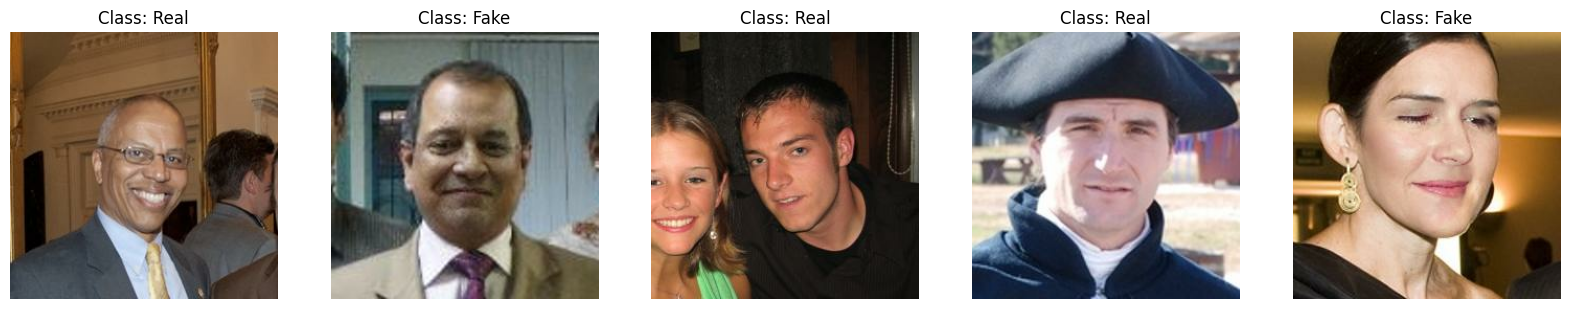

In [ ]:
for images, labels in train_data.take(1):
  # Visualiza las primeras 'n' imágenes
  n = 5
  plt.figure(figsize=(20, 20))
  for i in range(n):
      ax = plt.subplot(1, n, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # Suponiendo que tienes dos clases y la etiqueta [1, 0] corresponde a 'Fake' y [0, 1] a 'Real'
      label = 'Fake' if np.argmax(labels[i].numpy()) == 0 else 'Real'
      print(np.argmax(labels[i].numpy()) == 0,np.argmax(labels[i].numpy()))
      plt.title("Class: " + label)
      plt.axis("off")
  plt.show()

En el siguiente código hacemos un pre-procesado de las imágenes haciendo uso de la función "normalize_image", para normalizar los valores de los píxeles de imágenes a un rango [0, 1]. Esta normalización se realiza convirtiendo los píxeles a tipo float32 y dividiéndolos por 255.0. Esta función se aplica luego a los conjuntos de datos de entrenamiento, validación y prueba, asegurando que todas las imágenes sean procesadas uniformemente, lo cual es vital para el eficaz entrenamiento y evaluación de modelos de aprendizaje automático.

In [ ]:
def normalize_image(image, label):
    # Normaliza los píxeles de la imagen al rango [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplica la función de normalización a los conjuntos de datos
train_data = train_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
test_data = test_data.map(normalize_image)


Este bloque de código presenta la creación de una arquitectura de modelo de red neuronal convolucional (CNN) usando Keras. La estructura del modelo está diseñada para especializarse progresivamente, comenzando con capas convolucionales amplias y avanzando hacia capas más profundas en secuencia con capas de pooling. Además, se incorporan términos de regularización, cruciales en la optimización del gradiente descendente. Para mitigar el sobreajuste, se implementan técnicas como dropout y restricciones en el kernel (kernel_constraint).

A continuación se describe cada parámetro y función utilizada en el código:

*   Conv2D: Capa convolucional bidimensional, fundamental en redes neuronales convolucionales para el análisis de imágenes.

*   filters: Número de filtros (kernels) en la capa. Determina el número de características a detectar.

*   kernel_size: Tamaño del kernel/filtro en forma de tupla (alto, ancho). Indica el área de la imagen que cada filtro cubrirá.

*   strides: Tamaño de los pasos que el kernel dará sobre la imagen (alto, ancho). Afecta el tamaño de salida de la capa.

*   activation: Función de activación, 'relu' en este caso, introduce no linealidad en el modelo.

*   input_shape: Forma de la entrada (solo en la primera capa), especifica el tamaño de la imagen y los canales iniciales "3".

*   padding: Define cómo se manejan los bordes de las imágenes durante la convolución. "same" mantiene el mismo tamaño de salida, es muy importante ya que esto le permite al mdelo procesar los bordes más de una vez.

*   kernel_constraint: Restricción aplicada al kernel, MaxNorm(3) limita la norma máxima del kernel.

*   BatchNormalization: Normaliza las activaciones de la capa anterior, estabilizando y acelerando el entrenamiento.

*   MaxPooling2D: Capa de agrupación máxima.

*   pool_size: Tamaño del filtro de pooling (alto, ancho).

*   Dropout: Técnica de regularización. El parámetro (como 0.25) representa la fracción de unidades que se desactivarán aleatoriamente para evitar el sobreajuste.

*   Flatten: Aplana la entrada multidimensional en una matriz unidimensional para su uso en las capas de clasificación.

*   Dense: Capa densa o completamente conectada. El primer parámetro (como 1024) indica el número de neuronas en la capa.

*   activation: Función de activación, 'relu' para capas ocultas y 'softmax' para la capa de salida en clasificaciones multiclase o binarias.

In [ ]:
model1 = Sequential([
    # Primera capa convolucional
    Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Segunda capa convolucional
    Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Tercera capa convolucional
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Cuarta capa convolucional - reduciendo el tamaño del kernel
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Aplanar la salida para las capas densas
    Flatten(),

    # Capa densa
    Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)),
    Dropout(0.5),

    # Capa de salida
    Dense(2, activation='softmax')  # Softmax para clasificación binaria
])

Realizamos una previsualización del modelo previamente creado y vemos que está manejando una cantidad de parámetros igual a "2.796.226".

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        11648     
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 31, 31, 64)        2

Dibujamos la estructura del modelo directamente desde la función plot_model, la cual nos permite revisar de forma más dinámica todo el flujo de entrenamiento al que va a ser sometido el conjunto de datos de imágenes.

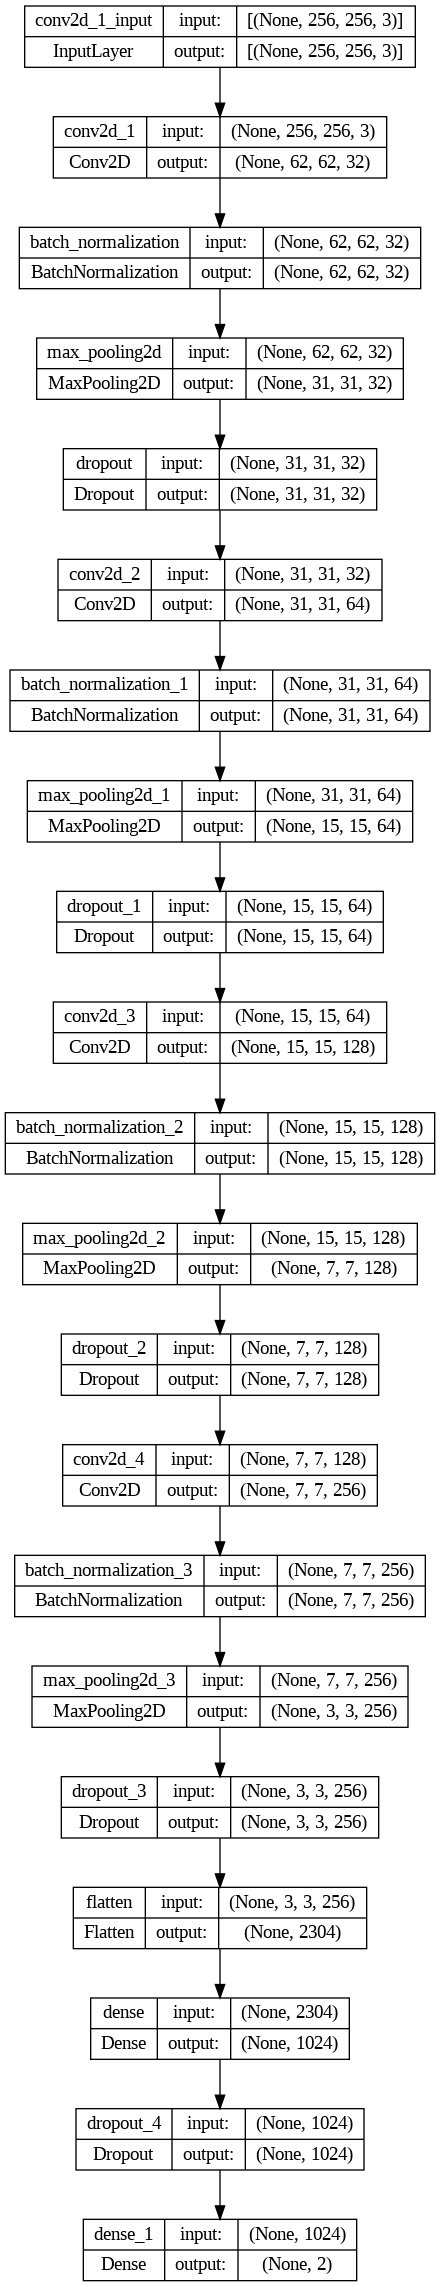

In [ ]:
plot_model(model1,show_shapes=True,to_file='cnn_structur.png')

Este bloque de código configura hiper-parámetros específicos para el entrenamiento. Inicialmente, se establecen 20 épocas (epochs) y una tasa de aprendizaje inicial (initial_lrate) de 0.01. Se crea un optimizador de Descenso de Gradiente Estocástico (SGD) con esta tasa de aprendizaje, un momento de 0.9, y sin el uso de Nesterov.

Luego, se define una función de decaimiento para la tasa de aprendizaje, que disminuye la tasa a lo largo de las épocas basándose en el decay_rate, calculado como la tasa de aprendizaje inicial dividida por el número de épocas.

Se utiliza un LearningRateScheduler como callback para ajustar la tasa de aprendizaje durante el entrenamiento según esta función de decaimiento.

Finalmente, el modelo se compila con una función de error llamada "categorical_crossentropy", utilizando el optimizador SGD configurado y monitorizando la precisión (accuracy) como métrica.


In [ ]:
# Parámetros iniciales
epochs = 20
initial_lrate = 0.01

# Crear el optimizador SGD sin el parámetro decay
sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

# Función para calcular el decaimiento de la tasa de aprendizaje
def decay(epoch, lrate):
    return initial_lrate / (1 + decay_rate * epoch)

decay_rate = initial_lrate / epochs
lrate_scheduler = LearningRateScheduler(lambda epoch: decay(epoch, initial_lrate))

# Compilar el modelo
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



In [ ]:
history = model1.fit(train_data, validation_data=validation_data, epochs=epochs, callbacks=[lrate_scheduler])

Epoch 1/20
4376/4376 [==============================] - 192s 42ms/step - loss: 0.6337 - accuracy: 0.6947 - val_loss: 0.5382 - val_accuracy: 0.7608 - lr: 0.0100
Epoch 2/20
4376/4376 [==============================] - 178s 41ms/step - loss: 0.4615 - accuracy: 0.7795 - val_loss: 0.4819 - val_accuracy: 0.7602 - lr: 0.0100
Epoch 3/20
4376/4376 [==============================] - 179s 41ms/step - loss: 0.3492 - accuracy: 0.8465 - val_loss: 0.2868 - val_accuracy: 0.8785 - lr: 0.0100
Epoch 4/20
4376/4376 [==============================] - 177s 40ms/step - loss: 0.2788 - accuracy: 0.8811 - val_loss: 0.2626 - val_accuracy: 0.8875 - lr: 0.0100
Epoch 5/20
4376/4376 [==============================] - 181s 41ms/step - loss: 0.2382 - accuracy: 0.9003 - val_loss: 0.2908 - val_accuracy: 0.8796 - lr: 0.0100
Epoch 6/20
4376/4376 [==============================] - 171s 39ms/step - loss: 0.2114 - accuracy: 0.9122 - val_loss: 0.2184 - val_accuracy: 0.9063 - lr: 0.0100
Epoch 7/20
4376/4376 [==================

El siguiente bloque de código va a crear dos curvas que representan la función de pérdida ('loss') a lo largo del número de épocas durante el entrenamiento de un modelo de red neuronal convolucional (CNN). Las dos curvas son:

Pérdida de Entrenamiento (loss): Indica cómo el modelo está aprendiendo específicamente en el conjunto de entrenamiento. Si vemos una tendencia decreciente quiere decir que el modelo está aprendiendo correctamente y mejorando su capacidad de ajustarse a los datos de entrenamiento con cada época, es decir, el error está convergiendo lo más que se puede hacia 0.

Pérdida de Validación (val_loss): Muestra el rendimiento del modelo en un conjunto de datos de validación, que no se utiliza para el entrenamiento y sirve para evaluar cómo el modelo generaliza a nuevos datos.

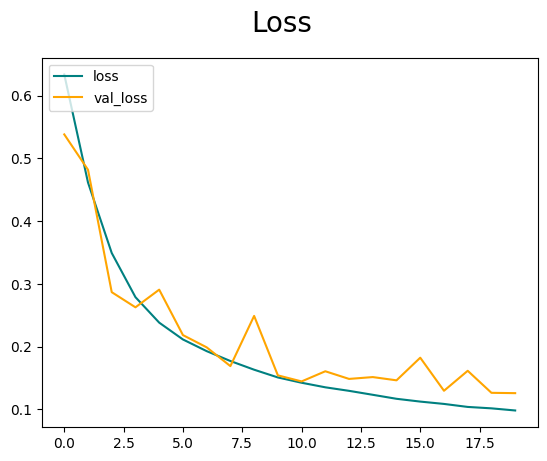

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

El siguiente bloque de código va a crear dos curvas también, pero con relación a la presición del modelo (accuracy), así mismo se presenta una curva para el conjunto de entrenamiento y para el conjunto de validación a lo largo de las épocas de entrenamiento:

Precisión de Entrenamiento (accuracy): si vemos un incremento en esta curva entenderíamos que el modelo está aprendiendo efectivamente del conjunto de entrenamiento. lo cual es un buen signo de aprendizaje efectivo y consistente.

Precisión de Validación (val_accuracy): si esta curva sigue una trayectoria similar a la de entrenamiento se podría decir que el modelo generaliza bien a nuevos datos. La precisión en el conjunto de validación alcanza y se mantiene cerca de la precisión de entrenamiento, lo cual es ideal.

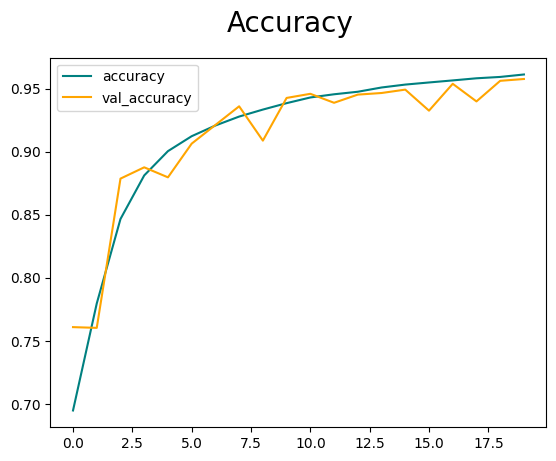

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

En esta parte del código realizamos la fase final del entrenamiento, que consiste en probar el rendimiento del modelo con imágenes que nunca ha visto antes.

In [ ]:
test_accuracy = model1.evaluate(test_data)

341/341 [==============================] - 11s 31ms/step - loss: 0.2439 - accuracy: 0.9121



El siguiente bloque de código evalúa la precisión del modelo utilizando el conjunto de datos de prueba, genera una matriz de confusión y un informe de clasificación detallado, y visualiza los resultados en un gráfico de calor para una interpretación rápida y clara del rendimiento del modelo.

341/341 [==============================] - 9s 26ms/step
              precision    recall  f1-score   support

        Real       0.90      0.93      0.91      5492
        Fake       0.93      0.89      0.91      5413

    accuracy                           0.91     10905
   macro avg       0.91      0.91      0.91     10905
weighted avg       0.91      0.91      0.91     10905



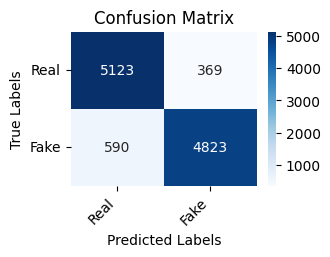

In [ ]:
predicted_probs = model1.predict(test_data, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)
test_labels = [labels for _ , labels in test_data]
test_labels = np.concatenate(test_labels, axis=0)
test_labels_0 = np.argmax(test_labels,axis=1)
cm = confusion_matrix(test_labels_0, predicted_labels)
accuracy = accuracy_score(test_labels_0, predicted_labels)
cm, accuracy

class_names = ['Real', 'Fake']
report = classification_report(test_labels_0, predicted_labels, target_names=class_names)
print(report)

plt.figure(figsize=(3, 2))
class_names = ['Real', 'Fake']
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

heatmap.set_xticklabels(class_names, rotation=45, ha='right')
heatmap.set_yticklabels(class_names, rotation=0)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


plt.show()

Finalmente guardamos el modelo =).

In [ ]:
model1.save('mi_modelo_entrenado.tf')